62
Features present in data: 62
Normalized expression shape: (62, 4)


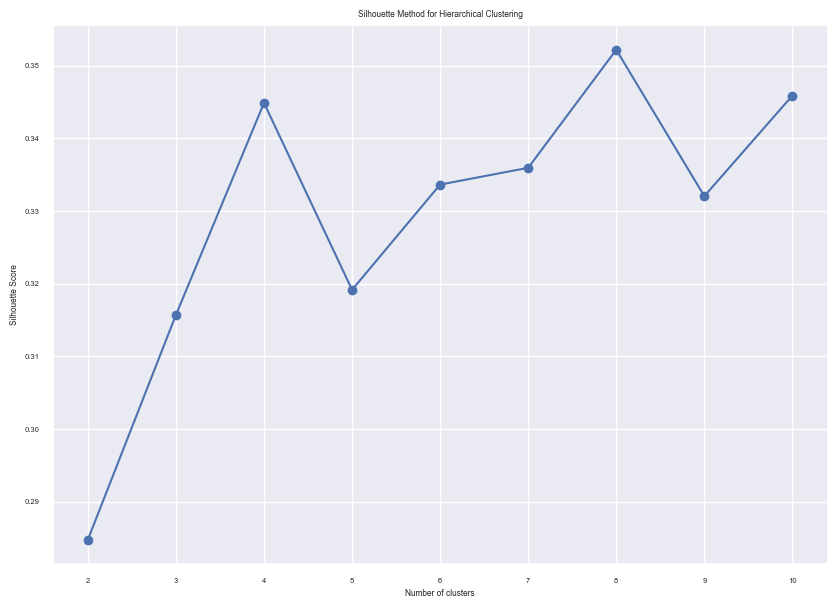

<Figure size 1500x1000 with 0 Axes>

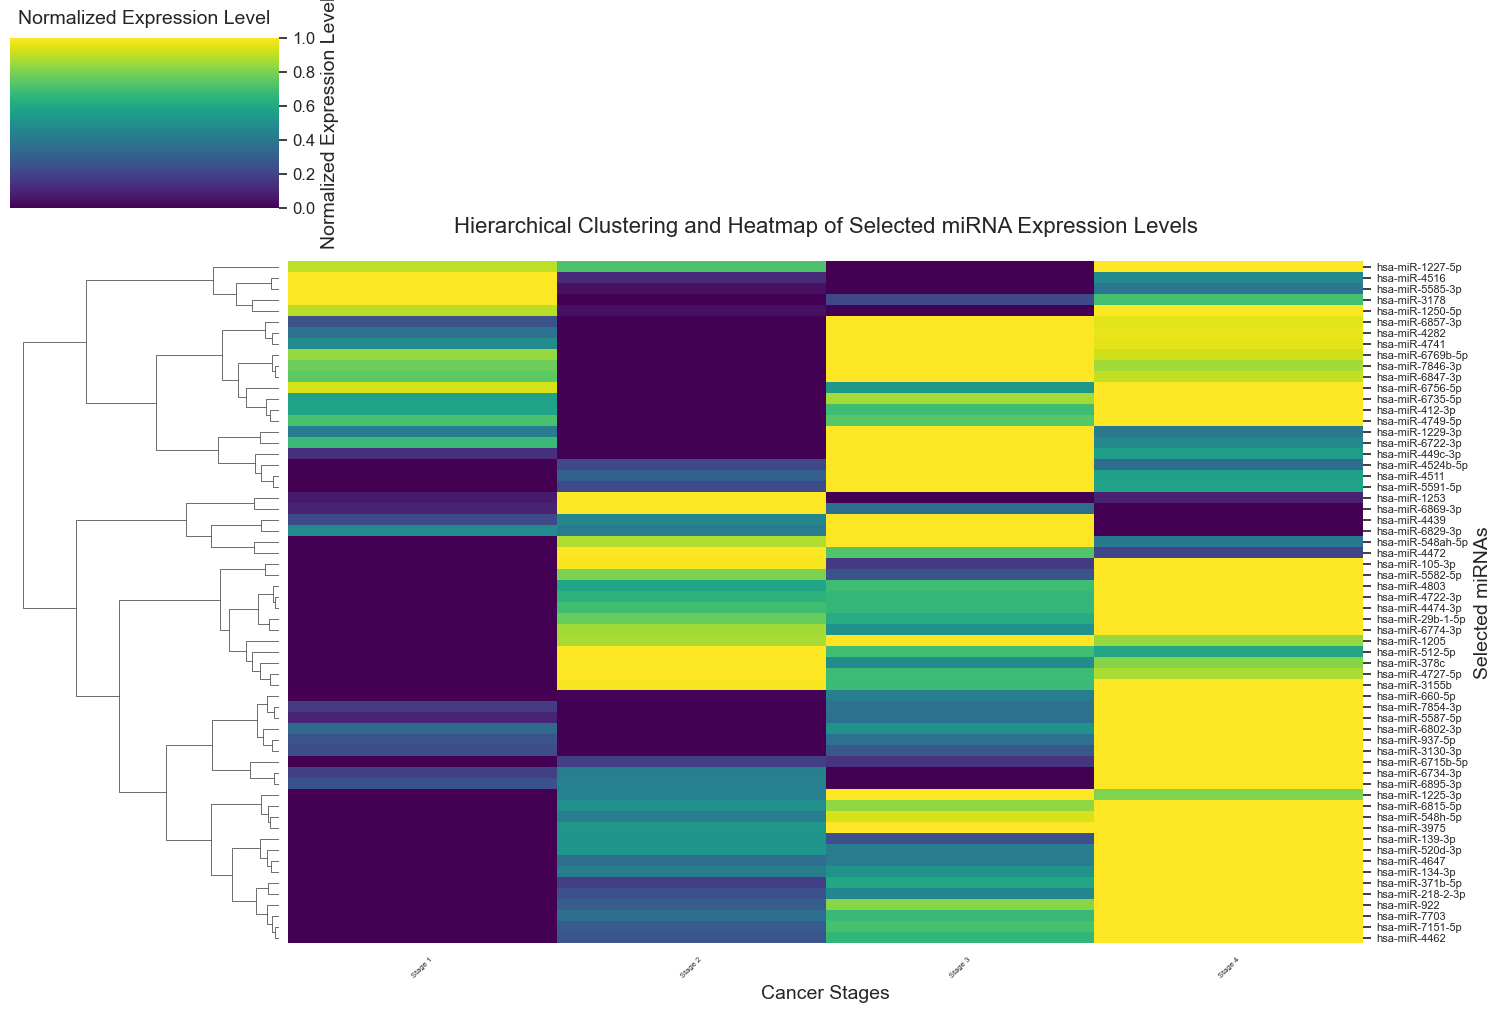

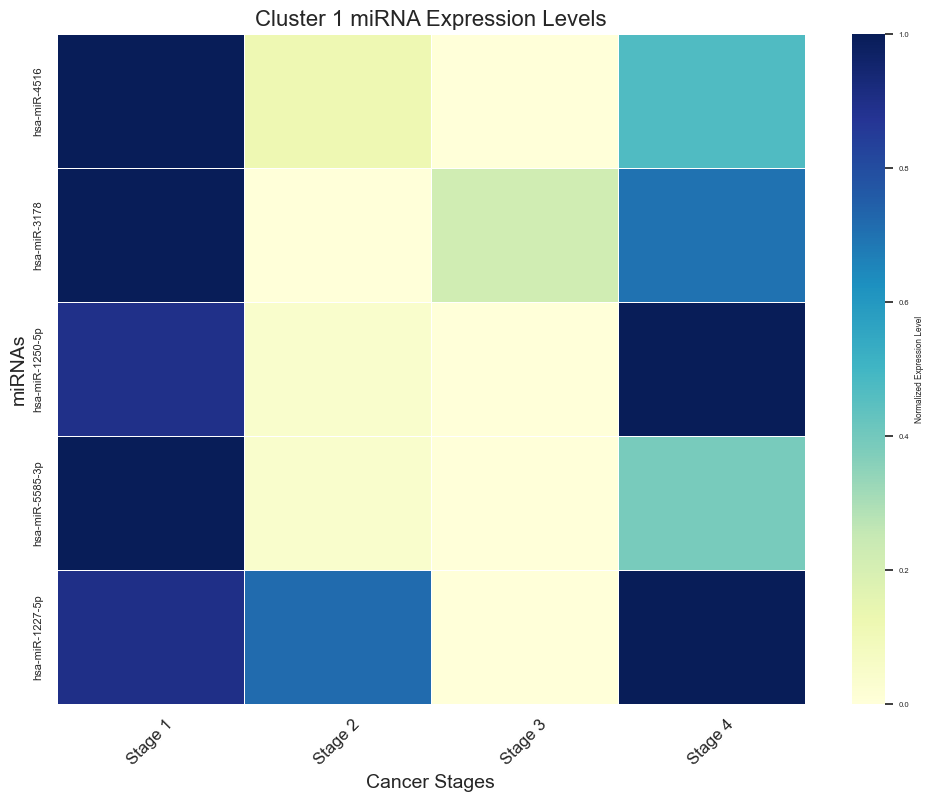

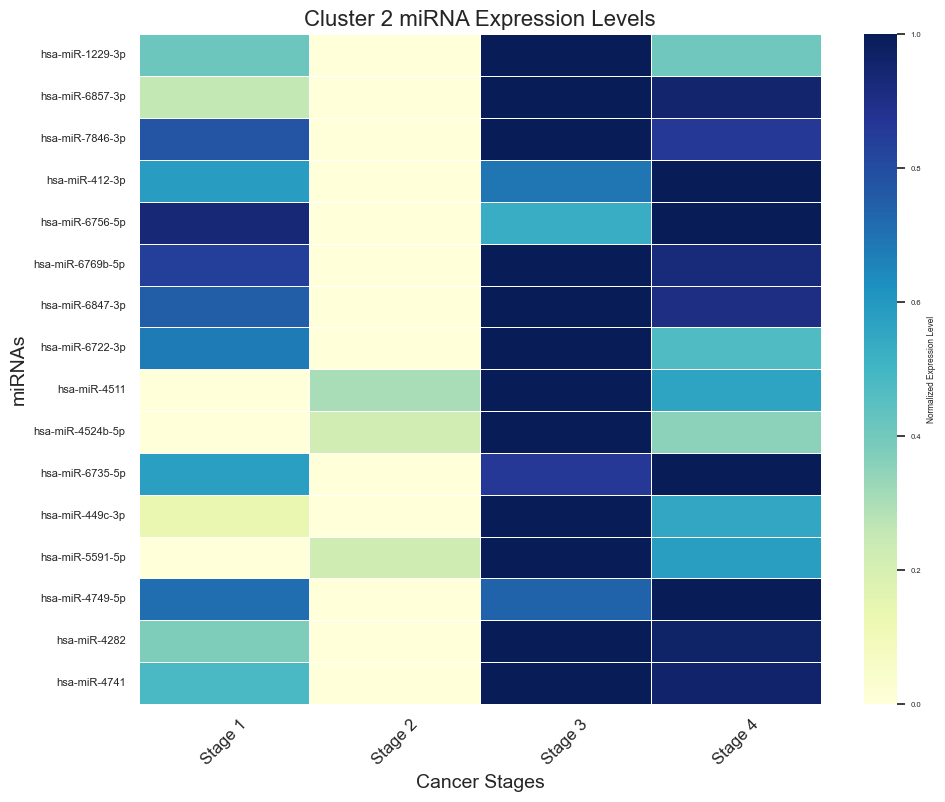

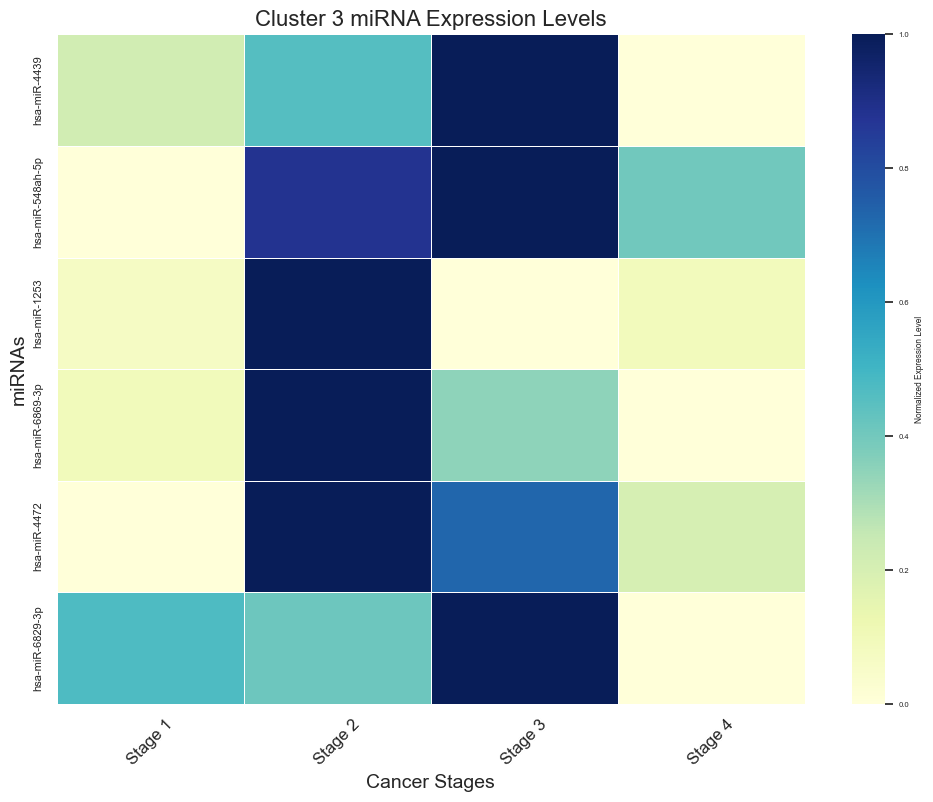

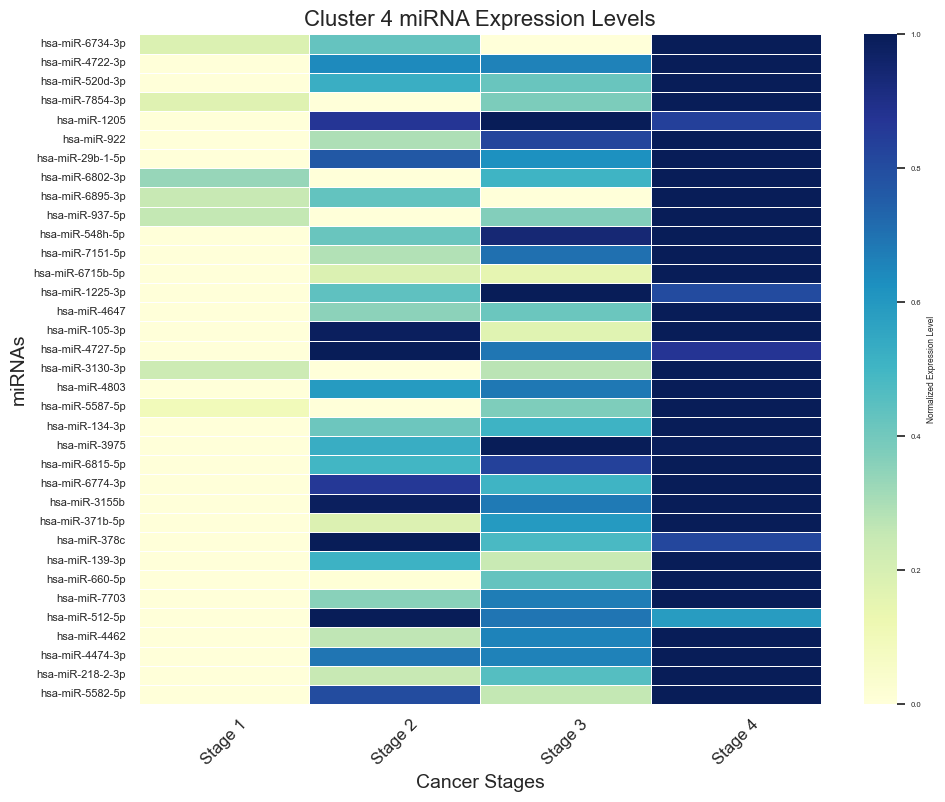

Cluster 1 Pathways:
- Signal Transduction
- Regulation of Activated PAK-2p34 By Proteasome Mediated Degradation
- NRP1-triggered Signaling Pathways in Pancreatic Cancer
- Gene Expression (Transcription)
- IL-2 Gene Expression in Activated and Quiescent T-Cells
- Cellular Senescence
- Nucleotide-binding Domain, Leucine Rich Repeat Containing Receptor (NLR) Signaling Pathways
- Transcription Androgen Receptor Nuclear Signaling
- AHR Pathway
- Signaling By Rho GTPases
- Spinal Cord Injury
- Regulation of TP53 Activity
- Transcriptional Regulation By The AP-2 (TFAP2) Family of Transcription Factors
- Sumoylation By RanBP2 Regulates Transcriptional Repression
- DREAM Repression and Dynorphin Expression
- RNA Polymerase I Promoter Opening
- Kynurenine Pathway and Links to Cell Senescence
- Proteolysis Putative SUMO-1 Pathway
- Cellular Responses to Stimuli
- Arf1 Pathway
- Angiotensin II Receptor Type 1 Pathway
- Insulin Receptor Signalling Cascade
- Heart Development
- DNA Damage
- Infectio

In [5]:
import pandas as pd
import seaborn as sns
from scipy.cluster.hierarchy import linkage, fcluster
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the feature files and combine the features
features_s1_s2 = pd.read_csv('./miRNA/50_s1_s2.csv')['Feature'].tolist()
features_s2_s3 = pd.read_csv('./miRNA/50_s2_s3.csv')['Feature'].tolist()
features_s3_s4 = pd.read_csv('./miRNA/50_s3_s4.csv')['Feature'].tolist()

all_selected_features = list(set(features_s1_s2 + features_s2_s3 + features_s3_s4))

print(len(all_selected_features))  # Ensure the total number of unique features
# Load and prepare the original stage data
stage_1_samples = pd.read_csv('../data/cancer/stage_1_prostate_cancer_samples.csv')
stage_2_samples = pd.read_csv('../data/cancer/stage_2_prostate_cancer_samples.csv')
stage_3_samples = pd.read_csv('../data/cancer/stage_3_prostate_cancer_samples.csv')
stage_4_samples = pd.read_csv('../data/cancer/stage_4_prostate_cancer_samples.csv')

# Add stage column for easier concatenation
stage_1_samples['Stage'] = 'Stage 1'
stage_2_samples['Stage'] = 'Stage 2'
stage_3_samples['Stage'] = 'Stage 3'
stage_4_samples['Stage'] = 'Stage 4'

# Combine all stages data
combined_data = pd.concat([stage_1_samples, stage_2_samples, stage_3_samples, stage_4_samples], ignore_index=True)

# Ensure only numeric columns are used
numeric_columns = combined_data.columns.drop(['Sample_ID', 'Sex', 'Age', 'Stage', 'Disease'])

# Calculate the average expression levels for each miRNA for each stage
average_expression = combined_data.groupby('Stage')[numeric_columns].mean().T

# Ensure all selected features are present in the data
selected_features_in_data = [feature for feature in all_selected_features if feature in average_expression.index]

print("Features present in data:", len(selected_features_in_data))

# Print missing features
missing_features = set(all_selected_features) - set(selected_features_in_data)
if missing_features:
    print("Missing features:", missing_features)

# Extract the selected features from the average expression data
selected_expression = average_expression.loc[selected_features_in_data]

# Normalize each miRNA across stages
normalized_expression = selected_expression.apply(lambda x: (x - x.min()) / (x.max() - x.min()), axis=1)

# Check if the normalization removes any miRNAs
print("Normalized expression shape:", normalized_expression.shape)
# Perform hierarchical clustering on the normalized data -- do complete link
linked = linkage(normalized_expression, method='ward')

# Determine the optimal number of clusters using Silhouette Method
max_clusters = 10
silhouette_scores = []
for i in range(2, max_clusters + 1):
    clusters = fcluster(linked, i, criterion='maxclust')
    silhouette_scores.append(silhouette_score(normalized_expression, clusters))

plt.figure(figsize=(10, 7))
plt.plot(range(2, max_clusters + 1), silhouette_scores, marker='o')
plt.title('Silhouette Method for Hierarchical Clustering')
plt.xlabel('Number of clusters')
plt.ylabel('Silhouette Score')
plt.show()

# Create a heatmap with dendrogram
plt.figure(figsize=(15, 10))
sns.set(font_scale=0.5)  # Reduce font scale for better visibility
clustermap = sns.clustermap(normalized_expression, row_linkage=linked, col_cluster=False, cmap='viridis', figsize=(15, 10))

# Enhance the heatmap
clustermap.ax_heatmap.set_title('Hierarchical Clustering and Heatmap of Selected miRNA Expression Levels', fontsize=16, pad=20)
clustermap.ax_heatmap.set_xlabel('Cancer Stages', fontsize=14)
clustermap.ax_heatmap.set_ylabel('Selected miRNAs', fontsize=14)
clustermap.ax_heatmap.tick_params(axis='x', rotation=45)

# Set y-tick labels to ensure all miRNAs are displayed
clustermap.ax_heatmap.set_yticklabels(clustermap.ax_heatmap.get_yticklabels(), rotation=0, fontsize=8)  # Adjust fontsize for y-tick labels

# Add color bar legend with a title
cbar = clustermap.ax_heatmap.collections[0].colorbar
cbar.set_label('Normalized Expression Level', fontsize=14)
cbar.ax.tick_params(labelsize=12)

# Set color bar title
cbar.ax.set_title('Normalized Expression Level', fontsize=14, pad=10)

plt.tight_layout()
plt.show()

# Assign clusters for 4 groups
num_clusters = 4
clusters = fcluster(linked, num_clusters, criterion='maxclust')

# Create a DataFrame for miRNA clusters
miRNA_clusters = pd.DataFrame({'miRNA': normalized_expression.index, 'Cluster': clusters})

# Save miRNA clusters to a CSV file (optional, for reference)
miRNA_clusters.to_csv('miRNA_clusters.csv', index=False)

# Function to create a heatmap for each cluster
def plot_cluster_heatmap(cluster_id, cluster_miRNAs, expression_data):
    # Extract expression data for the miRNAs in the cluster
    cluster_expression_data = expression_data.loc[cluster_miRNAs]

    # Plot the heatmap
    plt.figure(figsize=(10, 8))
    sns.heatmap(cluster_expression_data, cmap="YlGnBu", cbar_kws={'label': 'Normalized Expression Level'}, linewidths=.5)
    plt.title(f'Cluster {cluster_id} miRNA Expression Levels', fontsize=16)
    plt.xlabel('Cancer Stages', fontsize=14)
    plt.ylabel('miRNAs', fontsize=14)
    plt.xticks(rotation=45, fontsize=12)
    plt.yticks(fontsize=8)  # Adjust font size for y-tick labels
    plt.tight_layout()
    plt.show()

# Plot heatmap for each cluster
for cluster_id in range(1, num_clusters + 1):
    cluster_miRNAs = miRNA_clusters[miRNA_clusters['Cluster'] == cluster_id]['miRNA'].tolist()
    plot_cluster_heatmap(cluster_id, cluster_miRNAs, normalized_expression)

# Load gene and pathway data
group_1_gc = pd.ExcelFile('./gene_cards/group_1_gc.xlsx')
group_2_gc = pd.ExcelFile('./gene_cards/group_2_gc.xlsx')
group_3_gc = pd.ExcelFile('./gene_cards/group_3_gc.xlsx')
group_4_gc = pd.ExcelFile('./gene_cards/group_4_gc.xlsx')

group_1_pathways = pd.read_excel(group_1_gc, 'Pathways', skiprows=18)
group_2_pathways = pd.read_excel(group_2_gc, 'Pathways', skiprows=18)
group_3_pathways = pd.read_excel(group_3_gc, 'Pathways', skiprows=18)
group_4_pathways = pd.read_excel(group_4_gc, 'Pathways', skiprows=18)

# Filter top 10 pathways by 'Score' for each group
top_group_1_pathways = group_1_pathways.nlargest(10, 'Score')
top_group_2_pathways = group_2_pathways.nlargest(10, 'Score')
top_group_3_pathways = group_3_pathways.nlargest(10, 'Score')
top_group_4_pathways = group_4_pathways.nlargest(10, 'Score')

# Combine top pathways from all groups and drop duplicates
top_pathways = pd.concat([top_group_1_pathways, top_group_2_pathways, top_group_3_pathways, top_group_4_pathways]).drop_duplicates()

# Summarize pathways for each cluster
pathway_summaries = {}

for cluster_id in range(1, num_clusters + 1):
    cluster_miRNAs = miRNA_clusters[miRNA_clusters['Cluster'] == cluster_id]['miRNA'].tolist()
    pathways_in_cluster = set()

    for pathway in top_pathways['SuperPath Name'].unique():
        if pathway in group_1_pathways['SuperPath Name'].unique() or \
           pathway in group_2_pathways['SuperPath Name'].unique() or \
           pathway in group_3_pathways['SuperPath Name'].unique() or \
           pathway in group_4_pathways['SuperPath Name'].unique():
            pathways_in_cluster.add(pathway)

    pathway_summaries[cluster_id] = pathways_in_cluster

# Print pathway summaries for each cluster
for cluster_id, pathways in pathway_summaries.items():
    print(f"Cluster {cluster_id} Pathways:")
    for pathway in pathways:
        print(f"- {pathway}")
    print()
